DenseNets (Introduction to Deep Learning)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

## **tf.function on Fashion MNIST dataset**

---



9


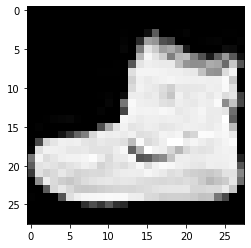

In [ ]:
mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_labels[0])
plt.imshow(train_images[0], cmap='Greys_r')

train_images = train_images.reshape([-1, 28, 28, 1])
train_images = train_images.astype(np.float32) / 255
test_images = test_images.reshape([-1, 28, 28, 1])
test_images = test_images.astype(np.float32) / 255

data = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=60000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels.astype(np.int32))).batch(128)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(28, 3, activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.Conv2D(56, 3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(10))
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 26, 26, 28)        280       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 24, 24, 32)        8096      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 10, 10, 56)        16184     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 56)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1400)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)             

In [ ]:
train_steps = 2500

opt = tf.optimizers.Adam(0.01)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
@tf.function
def grd(imgs, lbls):
  with tf.GradientTape() as t:
      logits = model(imgs)
      xent = loss_fn(lbls, logits)
      varis = model.trainable_variables
      grads = t.gradient(xent, varis)
      opt.apply_gradients(zip(grads, varis))
  return (logits, xent)

In [ ]:
start = time.time()
for step, (img_batch, lbl_batch) in enumerate(data):
    if step > train_steps:
        break

    logits, xent = grd(img_batch, lbl_batch)

    if (step % 100 == 0):
      train_acc_metric(lbl_batch, logits)
      acc = train_acc_metric.result()
      print("Loss: {} Accuracy: {}".format(xent, acc))
      train_acc_metric.reset_states()
stop = time.time()
print("Took {} seconds for execution.".format(stop - start)) 

Loss: 2.30424165725708 Accuracy: 0.1015625
Loss: 0.5172842741012573 Accuracy: 0.84375
Loss: 0.391462504863739 Accuracy: 0.84375
Loss: 0.575013279914856 Accuracy: 0.8125
Loss: 0.4069257378578186 Accuracy: 0.859375
Loss: 0.278542697429657 Accuracy: 0.9453125
Loss: 0.295225590467453 Accuracy: 0.8671875
Loss: 0.2816994786262512 Accuracy: 0.8828125
Loss: 0.31602028012275696 Accuracy: 0.8671875
Loss: 0.35142752528190613 Accuracy: 0.8828125
Loss: 0.2583279311656952 Accuracy: 0.8984375
Loss: 0.25307127833366394 Accuracy: 0.890625
Loss: 0.267647385597229 Accuracy: 0.8828125
Loss: 0.23480018973350525 Accuracy: 0.90625
Loss: 0.36754927039146423 Accuracy: 0.8984375
Loss: 0.2267988920211792 Accuracy: 0.9453125
Loss: 0.2522328794002533 Accuracy: 0.90625
Loss: 0.2720581889152527 Accuracy: 0.90625
Loss: 0.2542520761489868 Accuracy: 0.921875
Loss: 0.1580989509820938 Accuracy: 0.9375
Loss: 0.1860818862915039 Accuracy: 0.890625
Loss: 0.14757022261619568 Accuracy: 0.9453125
Loss: 0.21201904118061066 Accur

The training of Fashion MNIST dataset was done in 7.88 seconds usind tf.function annotation while the same dataset took 43.91 seconds for training.

In [ ]:
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))
print("Test acc: {}".format(test_acc_metric.result()))
test_acc_metric.reset_states()

Test acc: 0.9000999927520752


## **DenseNet**

---



[6]


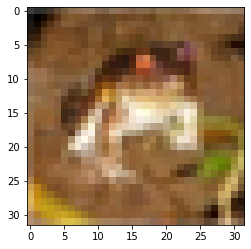

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_labels[0])
plt.imshow(train_images[0], cmap="Greys_r")

train_labels = train_labels.reshape((-1))
test_labels = test_labels.reshape((-1))

data = tf.data.Dataset.from_tensor_slices(
    (train_images.astype(np.float32) / 255, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=50000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.astype(np.float32) / 255, test_labels.astype(np.int32))).batch(128)

Model architecture is created with reference from [Semantic Segmentation Architecture](https://towardsdatascience.com/densenet-2810936aeebb) for fully Convolutional DenseNets and [Dense Blocks](https://d2l.ai/chapter_convolutional-modern/densenet.html#dense-blocks).

In [ ]:
def conv_block(filter_size, kernel_size):
  conv_blk = tf.keras.Sequential()
  conv_blk.add(tf.keras.layers.BatchNormalization())
  conv_blk.add(tf.keras.layers.Activation("relu"))
  conv_blk.add(tf.keras.layers.Conv2D(filter_size, kernel_size, padding= "same"))
  conv_blk.add(tf.keras.layers.Dropout(0.2))
  return conv_blk

In [ ]:
def dnsNet(inp, filter_size):
  conv1_1 = conv_block(filter_size, kernel_size= 3)(inp)

  conv1_2 = conv_block(filter_size, kernel_size= 3)(conv1_1)
  conc1 = tf.keras.layers.concatenate([conv1_1, conv1_2])
  conv1_3 = conv_block(filter_size, kernel_size= 3)(conc1)
  conc2 = tf.keras.layers.concatenate([conv1_1, conv1_3])
  conv1_4 = conv_block(filter_size, kernel_size= 3)(conc2)
  conc3 = tf.keras.layers.concatenate([conv1_1, conv1_4])
  conv1_5 = conv_block(filter_size, kernel_size= 3)(conc3)
  conc4 = tf.keras.layers.concatenate([conv1_1, conv1_5])
  conv1_6 = conv_block(filter_size, kernel_size= 3)(conc4)
  
  return tf.keras.layers.concatenate([conv1_1, conv1_6])

In [ ]:
inp = tf.keras.layers.Input((32, 32, 3))

conv1 = tf.keras.layers.Conv2D(32, 3, activation = tf.nn.relu, name= "1stConv")(inp)

filter_size = 50
dense1 = dnsNet(conv1, filter_size)

conv2 = conv_block(filter_size= 32, kernel_size= 1)(dense1)
inp2 = tf.keras.layers.MaxPool2D(2)(conv2)

filter_size = 50
dense2 = dnsNet(inp2, filter_size)

conv3 = conv_block(filter_size= 32, kernel_size= 1)(dense2)
inp3 = tf.keras.layers.MaxPool2D(2)(conv3)

flat = tf.keras.layers.Flatten()(inp3)
out = tf.keras.layers.Dense(10)(flat)


model = tf.keras.Model(inputs=inp, outputs=out, name='cifar10_model')
model.summary()

Model: "cifar10_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
1stConv (Conv2D)                (None, 30, 30, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
sequential_31 (Sequential)      (None, 30, 30, 50)   14578       1stConv[0][0]                    
__________________________________________________________________________________________________
sequential_32 (Sequential)      (None, 30, 30, 50)   22750       sequential_31[0][0]              
______________________________________________________________________________________

In [ ]:
opt = tf.optimizers.Adam()

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_acc_metric = tf.metrics.SparseCategoricalAccuracy()

model.compile(optimizer= opt, loss= loss_fn, metrics= [train_acc_metric])

model.fit(data, steps_per_epoch=2000, epochs=3)

Epoch 1/3
2000/2000 [==============================] - 104s 52ms/step - loss: 0.9804 - sparse_categorical_accuracy: 0.6524
Epoch 2/3
2000/2000 [==============================] - 104s 52ms/step - loss: 0.6023 - sparse_categorical_accuracy: 0.7893
Epoch 3/3
2000/2000 [==============================] - 104s 52ms/step - loss: 0.4712 - sparse_categorical_accuracy: 0.8349


In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 1s 14ms/step - loss: 0.7192 - sparse_categorical_accuracy: 0.7768


[0.7191673517227173, 0.7767999768257141]

Observation: Training accuracy for Cifar10 dataset with dense block of 6 layers was ~84% and the testing accuracy was 78%